## Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score


import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


## Import DataFrame

In [8]:
raw_df = pd.read_stata('1NHANES.dta')

# lower column names
raw_df.columns = [col.lower() for col in raw_df.columns]

## Clean DataFrame

In [9]:
# Physician Diabetes Dx
# 0 = No Dx; 1 = Yes Dx
raw_df['diq010'] = raw_df['diq010'].apply(lambda x: np.nan if (x == 3) |
                                          (x == 7) | (x == 9) else x)
raw_df['diq010'] = raw_df['diq010'].apply(lambda x: 0 if x == 2 else x)

# Sex
# 0 = Female; 1 = Male
raw_df['riagendr'] = raw_df['riagendr'].apply(lambda x: 0 if (x == 2) else x)

# Education
# HS and less = 0, less than college = 1, college or above = 2
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: np.nan
                                              if (x == 7) | (x == 9) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 0 if (x <= 3) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 1 if (x == 4) else x)
raw_df['dmdeduc2'] = raw_df['dmdeduc2'].apply(lambda x: 2 if (x == 5) else x)

# Moderate Physical Activity
raw_df["paq620"] = raw_df["paq620"].apply(lambda x: np.nan
                                              if (x == 7) | (x == 9) else x)
raw_df['paq620'] = raw_df['paq620'].apply(lambda x: 0 if (x == 2) else x)
# Citizenship
# 0 = No citizenship, 1 = Citizensip
raw_df['dmdcitzn'] = raw_df['dmdcitzn'].apply(lambda x: np.nan
                                              if (x == 7) | (x == 9) else x)
raw_df['dmdcitzn'] = raw_df['dmdcitzn'].apply(lambda x: 0 if x == 2 else x)

# Alcohol
# 1 = Yes, 0 = No
raw_df['alq101'] = raw_df['alq101'].apply(lambda x: np.nan if (x == 9) else x)
raw_df['alq101'] = raw_df['alq101'].apply(lambda x: 0 if (x == 2) else x)

# Veteran
# 1 = No, 0 = Yes
raw_df['dmqmiliz'] = raw_df['dmqmiliz'].apply(lambda x: np.nan
                                              if (x == 7) else x)
raw_df['dmqmiliz'] = raw_df['dmqmiliz'].apply(lambda x: 0 if (x == 2) else x)

# Smoke
# 1 = Yes, 0 = No
raw_df['smq020'] = raw_df['smq020'].apply(lambda x: np.nan
                                          if (x == 7) | (x == 9) else x)
raw_df['smq020'] = raw_df['smq020'].apply(lambda x: 0 if x == 2 else x)
# age
raw_df["ridageyr"] = raw_df["ridageyr"].apply(lambda x: x if x >=25 else np.nan)
# Diabetes - Clean after imputing missing values to appropriately categorize 0, 1, 2
df_y = raw_df['lbxgh']

## Predictors
predictors = [
    ('age', 'ridageyr'),
    ('bmi', 'bmxbmi'),
    ('bun', 'lbxsbu'),
#     ('race', 'ridreth3'),
#     ('education', 'dmdeduc2'),
    ('sex', 'riagendr'),
    ('diabetes_dx', 'diq010'),
    ('citizen', 'dmdcitzn'),
    ('alcohol', 'alq101'),
    ('veteran', 'dmqmiliz'),
    ('smoke', 'smq020'),
    ('systolicBP', 'bpxsy2'),
    ('mod_phys_activity', 'paq620'),
    ('ast', 'lbxsassi'),
    ('alt', 'lbxsatsi'),
]

dummies = [
#     ('diabetes_dx', 'diq010'),
    ('race', 'ridreth3'),
    ('education', 'dmdeduc2'),
#     ('sex', 'riagendr'),
#     ('alcohol', 'alq101'),
#     ('veteran', 'dmqmiliz'),
#     ('smoke', 'smq020'),
#     ('citizen', 'dmdcitzn'),
]

# Convert categorical variables into dummies - Don't Fall for Dummy Trap
cat_df = pd.DataFrame([])
for dum in dummies:
    cat_df[dum[0]] = raw_df[dum[1]]
    cat_df = pd.get_dummies(cat_df.astype('object'), drop_first=True)

cont_df = pd.DataFrame([])
for pred in predictors:
    cont_df[pred[0]] = raw_df[pred[1]]

# Concatenate predictors
df_x = pd.concat([cat_df, cont_df], axis=1)
# Concatenate dependent and predictors
df_main = pd.concat([df_y, df_x], axis=1)  # LOOK

# Rename column names
df = df_main.copy()
df = df.rename(
    columns={
        'lbxgh': 'diabetes',
        'race_2.0_1': 'Other Hispanic',
        'race_3.0_1': 'NH White',
        'race_4.0_1': 'NH Black',
        'race_6.0_1': 'Asian',
        'race_7.0_1': 'Others',
        'education_1.0': 'College - Not Graduated or Associates',
        'education_2.0': 'College degree or Above',
        'riagendr': 'sex',
        'diq010': 'diabetes_dx',
        'dmdcitzn': 'citizen',
        'alq101': 'alcohol',
        'dmqmiliz': 'veteran',
        'smq020': 'smoke',
        'bpxsy2': 'systolicBP',
        'lbxsatsi': 'alt',
        'lbxsassi': 'ast',
        'paq620': 'mod_phys_activity'
    })

## EDA

In [10]:
df.head()

,diabetes,Other Hispanic,NH White,NH Black,Asian,Others,College - Not Graduated or Associates,College degree or Above,age,bmi,...,sex,diabetes_dx,citizen,alcohol,veteran,smoke,systolicBP,mod_phys_activity,ast,alt
0,5.1,0,1,0,0,0,0,0,NaN,23.3,...,1.0,0.0,1.0,0.0,0.0,0.0,104.0,0.0,25.0,19.0
1,NaN,0,0,0,0,0,0,0,NaN,14.2,...,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.5,0,0,0,1,0,0,0,NaN,17.3,...,1.0,0.0,1.0,NaN,NaN,NaN,108.0,0.0,19.0,13.0
3,4.9,0,1,0,0,0,1,0,44.0,23.2,...,0.0,0.0,1.0,NaN,1.0,0.0,118.0,0.0,37.0,29.0
4,5.9,0,0,1,0,0,0,0,NaN,27.2,...,0.0,0.0,1.0,NaN,NaN,NaN,104.0,0.0,19.0,13.0


In [11]:
df.shape

(29902, 21)

In [12]:
df.dtypes

diabetes                                 float64
Other Hispanic                             uint8
NH White                                   uint8
NH Black                                   uint8
Asian                                      uint8
Others                                     uint8
College - Not Graduated or Associates      uint8
College degree or Above                    uint8
age                                      float64
bmi                                      float64
bun                                      float64
sex                                      float64
diabetes_dx                              float64
citizen                                  float64
alcohol                                  float64
veteran                                  float64
smoke                                    float64
systolicBP                               float64
mod_phys_activity                        float64
ast                                      float64
alt                 

diabetes                                 0.360779
Other Hispanic                           0.000000
NH White                                 0.000000
NH Black                                 0.000000
Asian                                    0.000000
Others                                   0.000000
College - Not Graduated or Associates    0.000000
College degree or Above                  0.000000
age                                      0.479868
bmi                                      0.116681
bun                                      0.371848
sex                                      0.000000
diabetes_dx                              0.055782
citizen                                  0.002007
alcohol                                  0.478563
veteran                                  0.384121
smoke                                    0.409906
systolicBP                               0.276637
mod_phys_activity                        0.301686
ast                                      0.372082


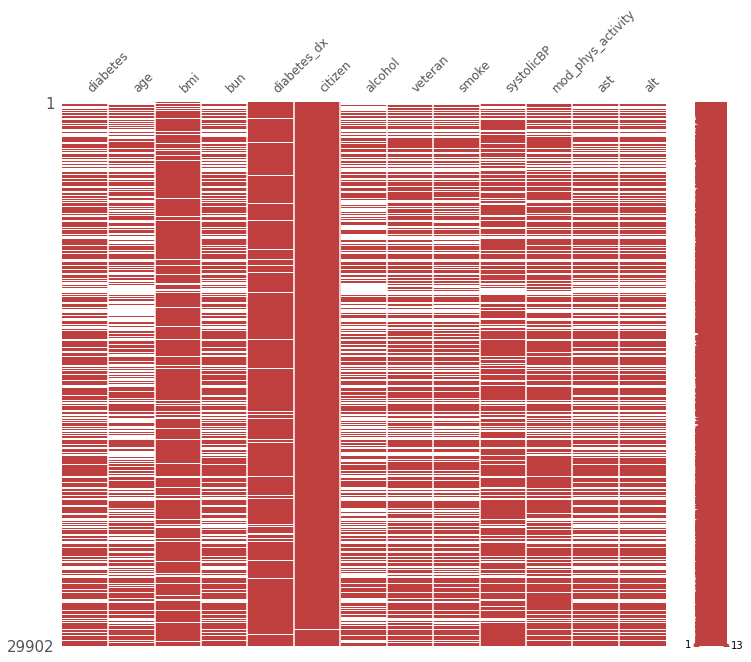

In [13]:
print(df.isna().sum() / len(df))
missingdata_df = df.columns[df.isnull().any()].tolist()
# Missing Data Heatmap
msno.matrix(df[missingdata_df],
            figsize=(12, 10),
            fontsize=12,
            color=(0.75, 0.25, 0.25))
plt.show()

In [16]:
cat = [
    'diabetes_dx', 'Other Hispanic', 'NH White', 'NH Black', 'Asian', 'Others',
    'sex', 'citizen', 'alcohol', 'veteran', 'smoke',
    'College - Not Graduated or Associates', 'College degree or Above',
    'mod_phys_activity'
]

df_cat = df[cat]
df_no_cat = df.drop(columns=(cat), axis=1)

### Impute NaNs with MICE

In [17]:
# Multiple Imputation
# no dummies
MICE_imputer = IterativeImputer()
df_MICE = df_no_cat.copy(deep=True)
df_MICE.iloc[:, :] = MICE_imputer.fit_transform(df_MICE)

# dummies
MICE_imputer2 = IterativeImputer()
df_cat_MICE = df_cat.copy(deep=True)
df_cat_MICE.iloc[:, :] = MICE_imputer2.fit_transform(df_cat_MICE)
df_cat_MICE = df_cat_MICE.astype(int)

df_full = pd.concat([df_MICE, df_cat_MICE], axis=1)

In [18]:
df_full.head()

,diabetes,age,bmi,bun,systolicBP,ast,alt,diabetes_dx,Other Hispanic,NH White,...,Asian,Others,sex,citizen,alcohol,veteran,smoke,College - Not Graduated or Associates,College degree or Above,mod_phys_activity
0,5.10000,45.493988,23.3,14.000000,104.000000,25.000000,19.000000,0,0,1,...,0,0,1,1,0,0,0,0,0,0
1,5.15487,47.221681,14.2,12.139719,108.419052,24.086718,18.179787,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,5.50000,50.821747,17.3,16.000000,108.000000,19.000000,13.000000,0,0,0,...,1,0,1,1,0,0,0,0,0,0
3,4.90000,44.000000,23.2,5.000000,118.000000,37.000000,29.000000,0,0,1,...,0,0,0,1,0,1,0,1,0,0
4,5.90000,44.970004,27.2,12.000000,104.000000,19.000000,13.000000,0,0,0,...,0,0,0,1,0,0,0,0,0,0


###  Transform A1c --> Non-Diabetes, Pre-diabetes, Diabetes 

In [19]:
df['diabetes'] = df['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df['diabetes'] = df['diabetes'].apply(lambda x: 1 if (x >= 6.5) else x)

df_full['diabetes'] = df_full['diabetes'].apply(lambda x: 0 if x < 6.5 else x)
df_full['diabetes'] = df_full['diabetes'].apply(lambda x: 1
                                                if (x >= 6.5) else x)

Text(0.5, 0, 'Diabetes')

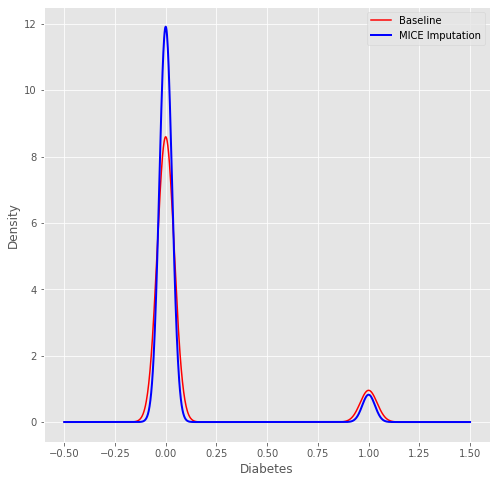

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
df['diabetes'].dropna().plot(kind='kde', c='red')
df_full['diabetes'].plot(kind='kde', c='blue', linewidth=2)
labels = ['Baseline', 'MICE Imputation']
plt.legend(labels)
ax.set_xlabel('Diabetes')

In [21]:
def get_target(df):
    df.loc[(df['diabetes'] == 0) & (df['diabetes_dx'] == 0), 'diabetes_cat'] = 0
    df.loc[(df['diabetes'] == 1) & (df['diabetes_dx'] == 0), 'diabetes_cat'] = 1
    df.loc[(df['diabetes'] == 1) & (df['diabetes_dx'] == 1), 'diabetes_cat'] = 2
    df = df.drop(columns=['diabetes', 'diabetes_dx'], axis=1)
    return df


df_full2 = get_target(df_full)

In [22]:
df_full2.isna().sum()

age                                        0
bmi                                        0
bun                                        0
systolicBP                                 0
ast                                        0
alt                                        0
Other Hispanic                             0
NH White                                   0
NH Black                                   0
Asian                                      0
Others                                     0
sex                                        0
citizen                                    0
alcohol                                    0
veteran                                    0
smoke                                      0
College - Not Graduated or Associates      0
College degree or Above                    0
mod_phys_activity                          0
diabetes_cat                             860
dtype: int64

In [23]:
# Drop lagging NAs
df_full2 = df_full2.dropna(axis=0)

In [24]:
df_copy = df_full2.copy()
df_copy2=df_copy.drop(columns=([i for i in cat if i not in ['diabetes_dx']]),axis=1)
df_copy3=df_copy.drop(columns=([i for i in df_copy.columns if i not in cat]),axis=1)
df_copy3=pd.concat([df_copy.diabetes_cat,df_copy3],axis=1)

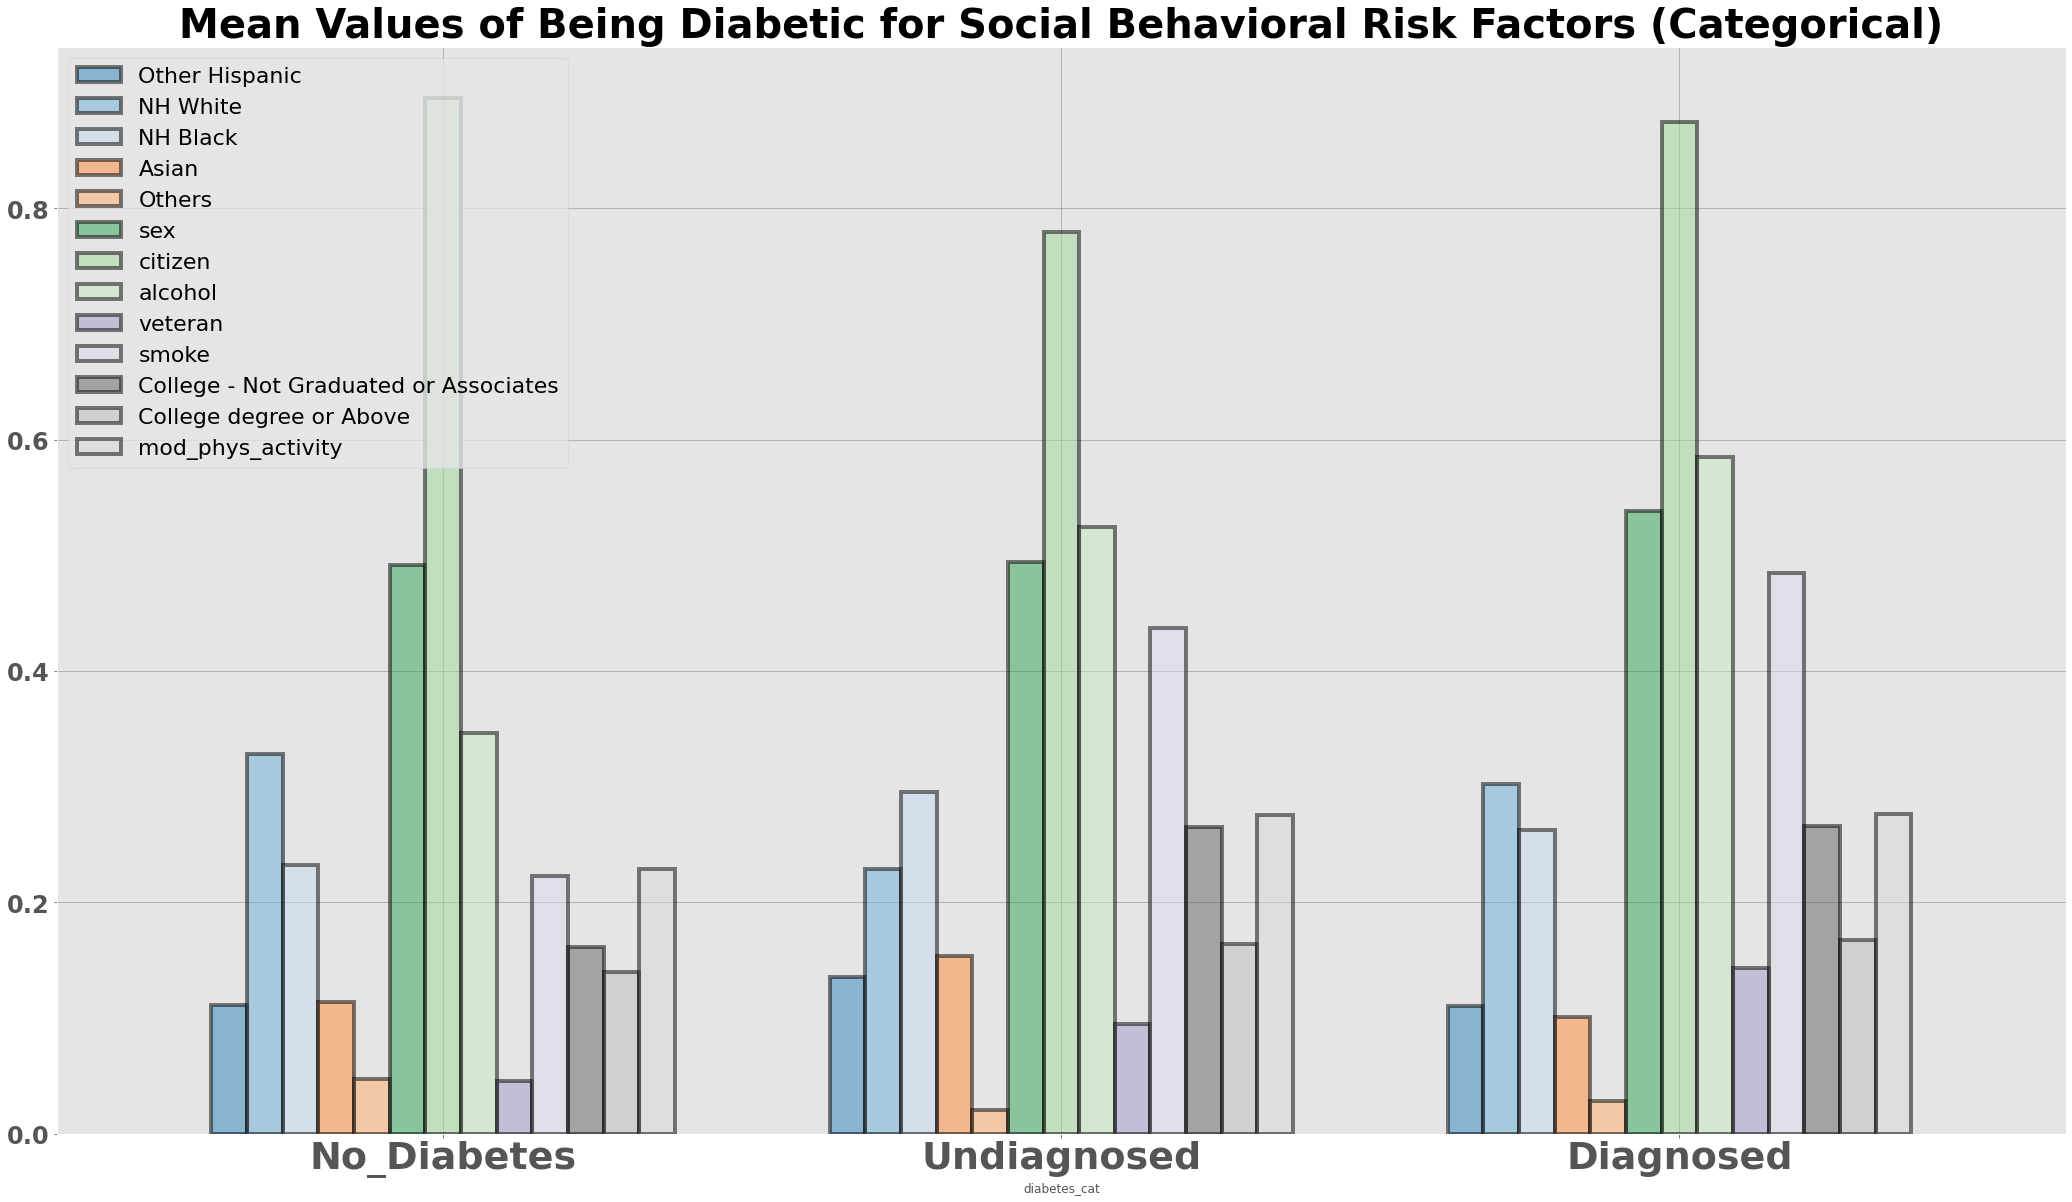

In [41]:
df_copy3.groupby('diabetes_cat').mean().plot(kind='bar',
                                             figsize=(36, 20),
                                             edgecolor='black',
                                             linewidth=4,
                                             alpha=0.5,
                                             cmap='tab20c',
                                             width=0.75)
plt.grid(color='grey',
         linestyle='-',
         linewidth=1,
         fillstyle='left',
         visible=True,
         alpha=0.5)
plt.title(
    'Mean Values of Being Diabetic for Social Behavioral Risk Factors (Categorical)',
    fontdict={
        "fontsize": 40,
        "fontweight": "black"
    })
plt.legend(fontsize=22, loc='upper left')
labels = ['No_Diabetes', 'Undiagnosed', 'Diagnosed']
plt.xticks(ticks=np.arange(len(df_full2['diabetes_cat'].unique())),
           labels=labels,
           rotation=0,
           fontsize=38,
           fontweight='black')
plt.yticks(fontsize=24, fontweight='black')
plt.show()

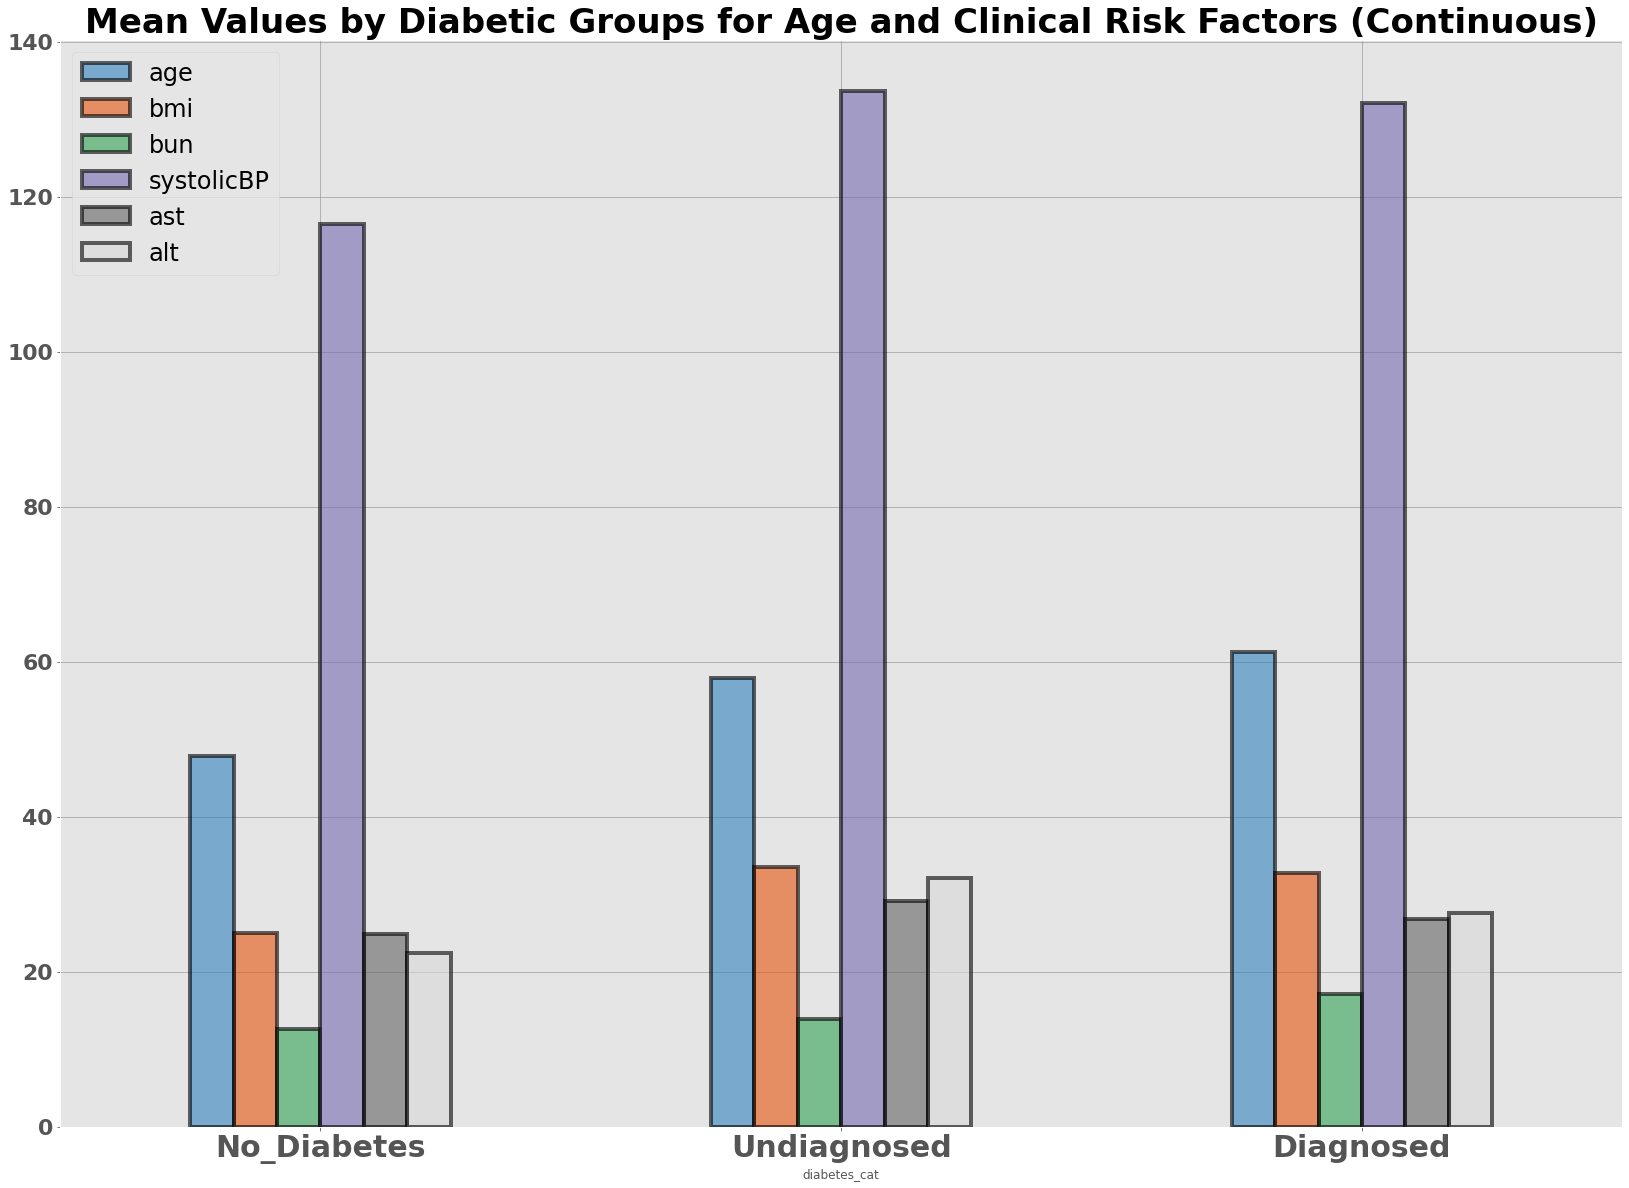

In [51]:
df_copy2.groupby('diabetes_cat').mean().plot(kind='bar',
                                        figsize=(28, 20),
                                        edgecolor='black',
                                        linewidth=4,
                                        alpha=0.6,
                                        cmap='tab20c'
                                       )
plt.grid(color='grey',
         linestyle='-',
         linewidth=1,
         fillstyle='left',
         visible=True,
         alpha=0.5)

plt.title('Mean Values by Diabetic Groups for Age and Clinical Risk Factors (Continuous)', 
          fontdict={"fontsize":34,"fontweight":"black"})
plt.legend(fontsize=24)
labels = ['No_Diabetes', 'Undiagnosed', 'Diagnosed']
plt.xticks(ticks=np.arange(len(df_full2['diabetes_cat'].unique())),
           labels=labels,
           rotation=0,
           fontsize=30,
           fontweight='black')
plt.yticks(fontsize=22, fontweight='black')
plt.show()

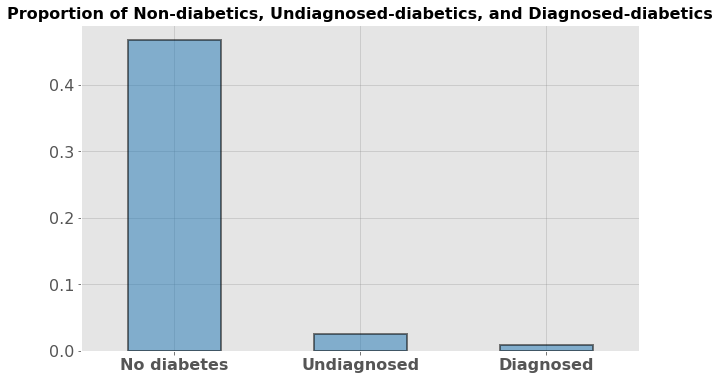

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = df_full2.diabetes_cat.value_counts(normalize=True).plot(kind='bar',
                                                             cmap='tab10',
                                                             alpha=0.5,
                                                             ax=ax,
                                                             linewidth=2,
                                                             edgecolor='black')
plt.grid(color='grey',
         linestyle='-',
         linewidth=.5,
         alpha=0.5,
         fillstyle='right',
         visible=True)

ax.set_title(
    'Proportion of Non-diabetics, Undiagnosed-diabetics, and Diagnosed-diabetics',
    fontdict={
        'fontsize': 16,
        'fontweight': 'black'
    })
ax.set_yticklabels(labels=np.round(np.arange(0, 1.1, 0.1), 2).tolist(),
                   fontsize=16)
ax.set_xticklabels(['No diabetes', 'Undiagnosed', 'Diagnosed'],
                   fontdict={
                       'fontsize': 16,
                       'rotation': 0,
                       'fontweight': "black"
                   })
plt.show()

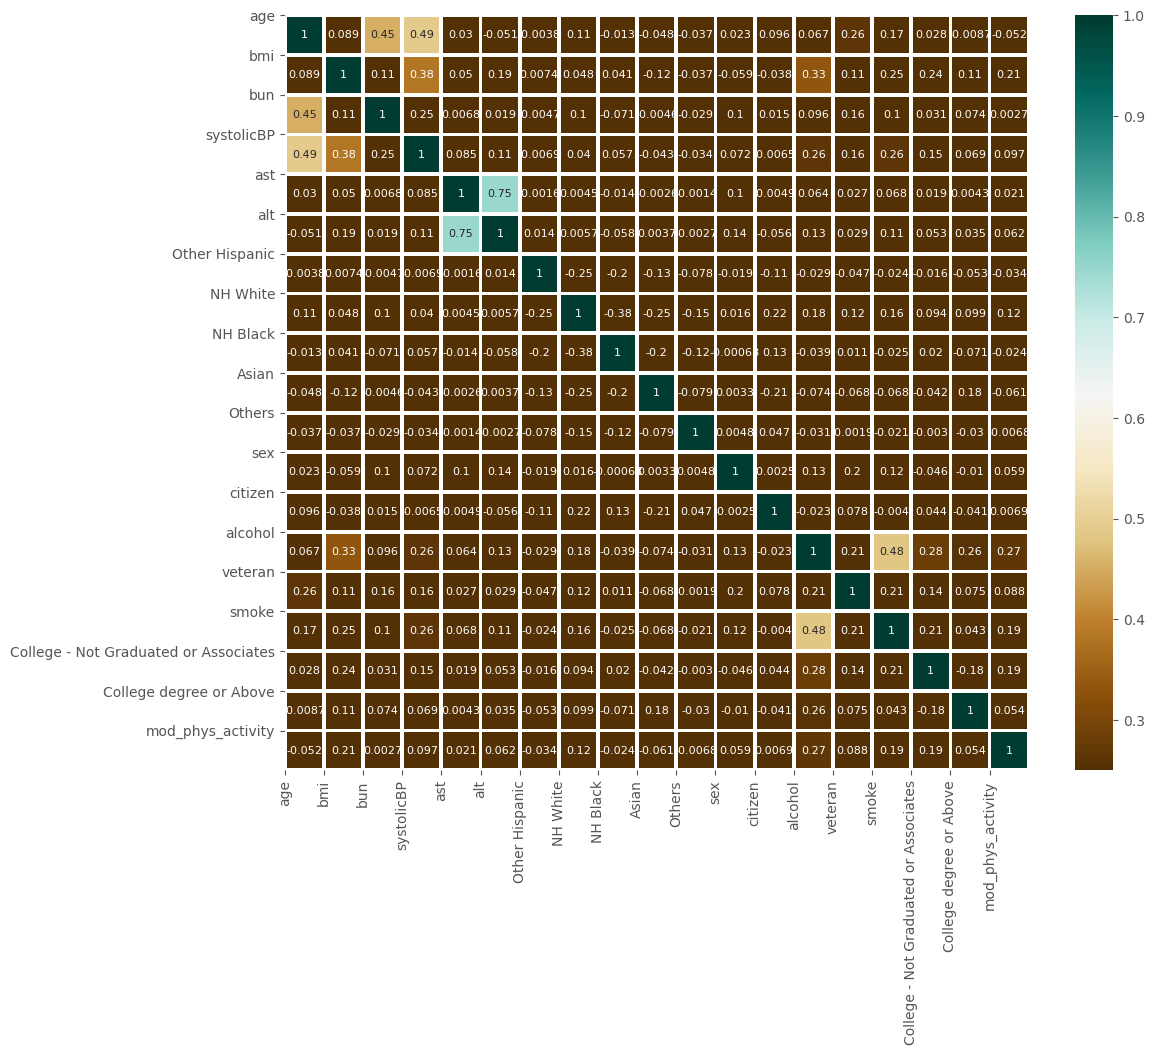

In [68]:
# Heatmap
fig, ax = plt.subplots(figsize=(12, 10), dpi=100)
c = df_full2.set_index('diabetes_cat').corr()
ax=sns.heatmap(
    c,
    vmin=0.25,
    cmap='BrBG',
    annot=True,
    linewidths=2,
    linecolor='white',
    annot_kws={'fontsize': 8},
)
ax.set_yticks(np.arange(len(df_full2.drop(columns='diabetes_cat', axis=1).columns.to_list())))
ax.set_yticklabels(labels=df_full2.drop(columns='diabetes_cat', axis=1).columns.to_list(),fontdict={'fontsize':10})
ax.set_xticks(np.arange(len(df_full2.drop(columns='diabetes_cat', axis=1).columns.to_list())))
ax.set_xticklabels(labels=df_full2.drop(columns='diabetes_cat', axis=1).columns.to_list(),fontdict={'fontsize':10}, rotation =90)

plt.show();

### Preprocess

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
normalize = Normalizer()
scaler = StandardScaler()


In [70]:
y = df_full2.diabetes_cat
X = df_full2.drop(columns='diabetes_cat', axis=1)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123,
                                                    stratify=y.tolist())

In [72]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [73]:
# normalize.fit(X_train)
X_train = normalize.fit_transform(X_train)
X_test = normalize.fit_transform(X_test)

### Modeling

In [86]:
def run_clf(clf, X_train, X_test, y_train, y_test):

    clf_ = clf
    clf_.fit(X_train, y_train)
    y_pred = clf_.predict(X_test)

    # Confusion matrix and classification report
    cm = confusion_matrix(y_test, y_pred, labels=clf_.classes_)
    classes = ['Non-Diabetic', 'Undiagnosed', 'Diagnosed']
    cr = classification_report(y_test, y_pred, labels=clf_.classes_)
    print(classification_report(y_test, y_pred))

    return cm, classes, clf, cr


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix - Logistic Regression',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix - Logistic Regression')

    print(cm)
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Instantiate Models

In [87]:
from sklearn.svm import LinearSVC
from sklearn.metrics import recall_score
from sklearn.svm import SVC

linear_svc = LinearSVC(multi_class='ovr',
                       fit_intercept=True,
                       intercept_scaling=1,
                       class_weight='balanced',
                       loss='hinge',
                       C=50,
                       random_state=123)

svc_rbf = SVC(class_weight='balanced',
              C=0.1,
              kernel='rbf',
              degree=3,
              gamma='auto',
              tol=0.001,
              max_iter=-1,
              decision_function_shape='ovr',
              random_state=123)

logreg = LogisticRegression(multi_class='ovr',
                            class_weight='balanced',
                            solver='saga',
                            penalty='elasticnet',
                            l1_ratio=0.11,
                            random_state=123)

#### Linear SVC OVR

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92      5422
         1.0       0.08      0.47      0.14        99
         2.0       0.23      0.27      0.25       288

    accuracy                           0.84      5809
   macro avg       0.43      0.54      0.44      5809
weighted avg       0.92      0.84      0.88      5809

Normalized confusion matrix
[[0.87919587 0.07598672 0.04481741]
 [0.39393939 0.47474747 0.13131313]
 [0.37152778 0.36111111 0.26736111]]


<Figure size 600x600 with 0 Axes>

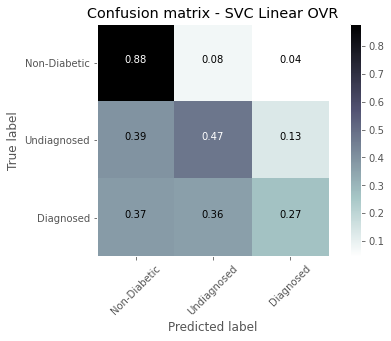

In [88]:
import itertools
cm, classes, linear_svc, cr = run_clf(linear_svc, X_train, X_test, y_train,
                                        y_test)

plt.figure(figsize=(6, 6), dpi=100)

plot_confusion_matrix(cm,
                      classes,
                      normalize=True,
                      title='Confusion matrix - SVC Linear OVR',
                      cmap='bone_r')

plt.grid(visible=False)
plt.show();

#### SVM Kernel RBF OVR

              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81      5422
         1.0       0.06      0.65      0.11        99
         2.0       0.15      0.51      0.23       288

    accuracy                           0.68      5809
   macro avg       0.40      0.62      0.39      5809
weighted avg       0.93      0.68      0.77      5809

Normalized confusion matrix
[[0.68959793 0.15676872 0.15363335]
 [0.08080808 0.64646465 0.27272727]
 [0.08333333 0.40277778 0.51388889]]


<Figure size 600x600 with 0 Axes>

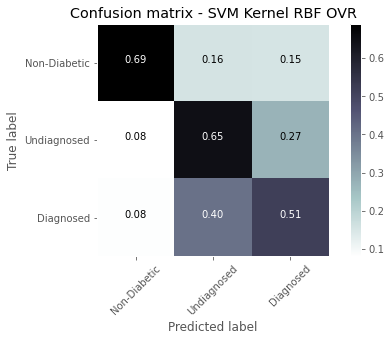

In [89]:
cm, classes, svc_rbf, cr = run_clf(svc_rbf, X_train, X_test, y_train,
                                        y_test)

plt.figure(figsize=(6, 6), dpi=100)

plot_confusion_matrix(cm,
                      classes,
                      normalize=True,
                      title='Confusion matrix - SVM Kernel RBF OVR',
                      cmap='bone_r')

plt.grid(visible=False)
plt.show();

#### Logistic Regression OVR

              precision    recall  f1-score   support

         0.0       0.99      0.65      0.79      5422
         1.0       0.04      0.82      0.08        99
         2.0       0.13      0.19      0.16       288

    accuracy                           0.63      5809
   macro avg       0.39      0.55      0.34      5809
weighted avg       0.93      0.63      0.74      5809

Normalized confusion matrix
[[0.65418665 0.282737   0.06307636]
 [0.08080808 0.81818182 0.1010101 ]
 [0.11458333 0.69791667 0.1875    ]]


<Figure size 600x600 with 0 Axes>

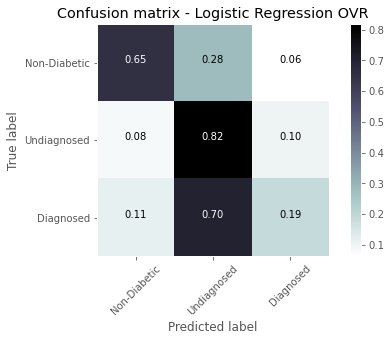

In [90]:
cm, classes, logreg, cr = run_clf(logreg, X_train, X_test, y_train, y_test)
plt.figure(figsize=(6,6), dpi=100)
plot_confusion_matrix(
    cm,
    classes,
    normalize=True,
    title='Confusion matrix - Logistic Regression OVR',
    cmap='bone_r')
plt.grid(visible=False)
plt.show();